In [8]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# tools for applying bundle adjustment to a temporal sequence of satellite images
import bundle_adjust.ba_timeseries as ba_timeseries

from bundle_adjust import data_loader as loader
from PIL import Image
import glob
import rpcm

# Display and interface settings (just for the notebook interface)
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Copy  pc3dr output as rasterized dsms equivalent to the BA ones

In [15]:
t_id = '20190128_204710'
rec4D_dir =  '/home/rogermm14/sat-bundleadjust/exp/mine_L1A/ba_global/4D'
pc3dr_in_dir = '/home/anger/for_roger/reg'
s2p_dir = os.path.join(rec4D_dir, 's2p/{}'.format(t_id))

dsm_resolution = 0.8

print('done')

done


In [35]:
s2p_dsm_fnames = loader.load_s2p_dsm_fnames_from_dir(s2p_dir)

all_ply_fnames = []
for idx, s2p_dsm_fn in enumerate(s2p_dsm_fnames):
    pc3dr_path_to_ply_files = os.path.dirname(s2p_dsm_fn).replace(s2p_dir, pc3dr_in_dir)
    pc3dr_ply_fnames = glob.glob(os.path.join(pc3dr_path_to_ply_files, '**/*.ply'), recursive=True)
    if len(pc3dr_ply_fnames) == 0:
        continue
    ba_ply_fnames = glob.glob(os.path.join(os.path.dirname(s2p_dsm_fn), '**/*.ply'), recursive=True)
    all_ply_fnames.extend(ba_ply_fnames)
    
complete_dsm_fname = os.path.join(rec4D_dir, 'dsms/{}_ba_1-0.tif'.format(t_id))
args = [' '.join(all_ply_fnames), complete_dsm_fname, dsm_resolution]
cmd = "plyflatten {} {} --resolution {}".format(*args)
os.system(cmd)

print('{} successfully created'.format(complete_dsm_fname))

/home/rogermm14/sat-bundleadjust/exp/mine_L1A/ba_global/4D/dsms/20190128_204710_ba_1-0.tif successfully created


In [33]:
complete_dsm_fname = os.path.join(rec4D_dir, 'dsms/{}_pc3dr.tif'.format(t_id))
args = [pc3dr_in_dir, complete_dsm_fname, dsm_resolution]
cmd = "plyflatten $(find {} -name 'cloud.ply') {} --resolution {}".format(*args)
os.system(cmd)

print('{} successfully created'.format(complete_dsm_fname))

/home/rogermm14/sat-bundleadjust/exp/mine_L1B/ba_global/4D/dsms/20190128_204710_pc3dr.tif successfully created


### Compare std pc3dr with std BA

In [10]:
from bundle_adjust import ba_metrics

pc3dr_dsms_fnames = loader.load_s2p_dsm_fnames_from_dir(s2p_dir.replace('/s2p/', '/pc3dr/'))
std_per_date_dir = os.path.join(rec4D_dir, 'metrics_pc3dr/std_per_date')

ba_metrics.compute_std_for_specific_date_from_tiles(complete_dsm_fname, pc3dr_dsms_fnames,
                                                    output_dir=std_per_date_dir)


###################################################################################
Computing std for specific date...
  - complete_dsm_fname: /home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/dsms/20190128_204710_pc3dr.tif
  - tile_size: 500
###################################################################################


Clipping dsms...
116 dsms / 116
Done!

616 tiles / 616
Done!



/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/metrics_pc3dr/std_per_date/20190128_204710_pc3dr_std.tif 
median std: 0.162 / average std: 6.610


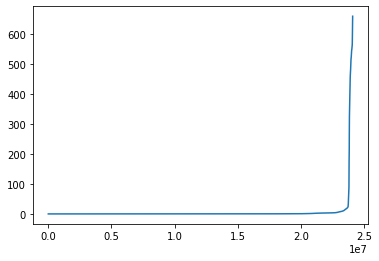

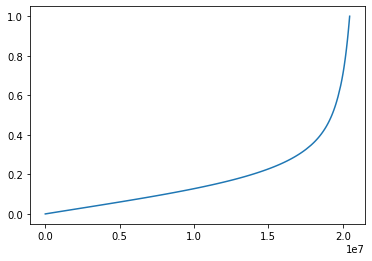

In [23]:
#
# pc3dr
#

std_fname = os.path.join(rec4D_dir, 'metrics_pc3dr/std_per_date/{}_pc3dr_std.tif'.format(t_id))

im = np.array(Image.open(std_fname)).flatten()
im = np.sort(im[~np.isnan(im)])

print('{} \nmedian std: {:.3f} / average std: {:.3f}'.format(std_fname, np.median(im), np.mean(im)))
plt.plot(im)
plt.show()

plt.plot(im[im < 1.])
plt.show()


/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/std_ba.tif 
median std: 0.250 / average std: 0.362


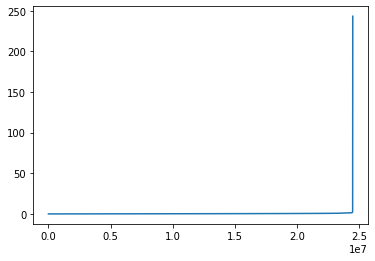

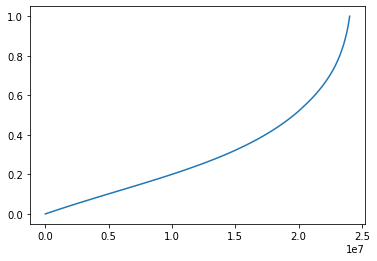

In [22]:
#
# bundle adjustment 
#
      
std_fname = os.path.join(rec4D_dir, 'std_ba.tif')
    
im = np.array(Image.open(std_fname)).flatten()
im = np.sort(im[~np.isnan(im)])
      
print('{} \nmedian std: {:.3f} / average std: {:.3f}'.format(std_fname, np.median(im), np.mean(im)))
plt.plot(im)
plt.show()

plt.plot(im[im < 1.])
plt.show()


/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/metrics/std_per_date/20190128_204710_std.tif 
median std: 0.322 / average std: 0.432


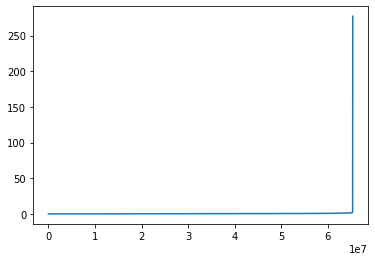

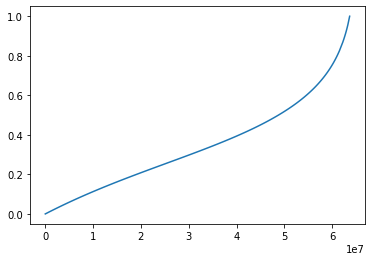

In [24]:
std_fname = os.path.join(rec4D_dir, 'metrics/std_per_date/{}_std.tif'.format(t_id))

im = np.array(Image.open(std_fname)).flatten()
im = np.sort(im[~np.isnan(im)])
      
print('{} \nmedian std: {:.3f} / average std: {:.3f}'.format(std_fname, np.median(im), np.mean(im)))
plt.plot(im)
plt.show()

plt.plot(im[im < 1.])
plt.show()

### Remove outliers from std maps

In [12]:
std_fname = 'exp/mine_L1A/ba_global/4D/dsms/20190128_204710_std.tif'

im = np.array(Image.open(std_fname))
im[im>3] = np.nan

Image.fromarray(im).save(loader.add_suffix_to_fname(std_fname, 'v2'))

/home/rogermm14/.local/lib/python3.6/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (146249088 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/rogermm14/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


### Generate L1A-rpcfix config.json

In [9]:
L1B_s2p_configs_dir = '/home/anger/for_roger/s2p'
L1A_s2p_configs_dir = '/home/rogermm14/morenci_L1A_s2p'

L1A_geotiff_dir = '/home/anger/for_roger/L1A_Fast-rpcfix'


src_config_fnames = glob.glob(os.path.join(L1B_s2p_configs_dir, '**/config.json'), recursive=True)

dst_config_fnames = [fn.replace(L1B_s2p_configs_dir, L1A_s2p_configs_dir)  for fn in src_config_fnames]

for src_config_fname, dst_config_fname in zip(src_config_fnames, dst_config_fnames):
    
    os.makedirs(os.path.dirname(dst_config_fname), exist_ok=True)
    
    config_s2p = loader.load_dict_from_json(src_config_fname)
    
    # correct image filenames and rpcs
    for i in [0,1]:
        img_basename = os.path.basename(config_s2p['images'][i]['img'])
        img_basename = img_basename.replace('basic_panchromatic', 'basic_l1a_panchromatic')
        img_geotiff_path = glob.glob('{}/**/{}'.format(L1A_geotiff_dir, img_basename), recursive=True)[0]
        config_s2p['images'][i]['img'] = img_geotiff_path
        config_s2p['images'][i]['rpc'] = rpcm.rpc_from_geotiff(img_geotiff_path).__dict__
        
    # delete roi and utm_bbox if existent
    if 'utm_bbx' in config_s2p.keys():
        del config_s2p['utm_bbx'] 
    if 'roi' in config_s2p.keys():
        del config_s2p['roi']
    
    loader.save_dict_to_json(config_s2p, dst_config_fname)
    
print('done creating L1A config.json')

done creating L1A config.json


In [36]:
L1A_rec4D_dir =  '/home/rogermm14/sat-bundleadjust/exp/mine_L1A/ba_global/4D'

L1A_dsm_fnames = loader.load_s2p_dsm_fnames_from_dir(L1A_rec4D_dir)

L1B_rec4D_dir =  '/home/rogermm14/sat-bundleadjust/exp/mine_L1B/ba_global/4D'

L1B_dsm_fnames = loader.load_s2p_dsm_fnames_from_dir(L1B_rec4D_dir)

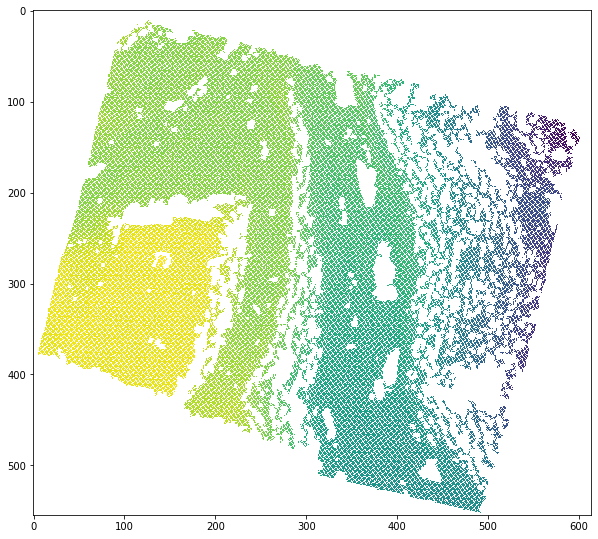

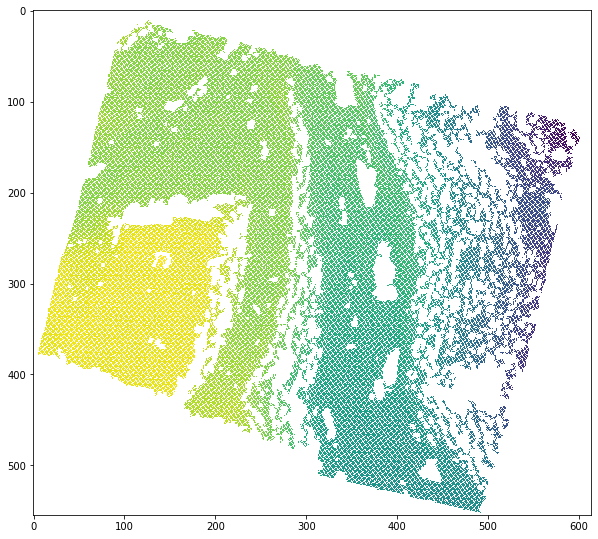

In [76]:
chosen_idx = np.random.choice(np.arange(len(L1A_dsm_fnames)))

l1a_fn = L1A_dsm_fnames[chosen_idx]

l1b_fn = l1a_fn.replace('/mine_L1B/', '/mine_L1A/')

l1a_dsm = np.array(Image.open(l1a_fn))
l1b_dsm = np.array(Image.open(l1b_fn))

fig = plt.figure(figsize=(10,10))
plt.imshow(l1a_dsm)
plt.show()
fig = plt.figure(figsize=(10,10))
plt.imshow(l1b_dsm)
plt.show()

### Fill small holes in the output dsms

In [84]:
t_id = '20190128_204710'
rec4D_dir =  '/home/rogermm14/sat-bundleadjust/exp/mine_L1A/ba_global/4D'
s2p_dir = os.path.join(rec4D_dir, 's2p/{}'.format(t_id))

s2p_dsm_fnames = loader.load_s2p_dsm_fnames_from_dir(s2p_dir)

imscript_bin_dir = 'bin'

for dsm_idx, dsm_fn in enumerate(s2p_dsm_fnames):
    cdsm_fn = dsm_fn.replace('/dsm.tif', '/cdsm.tif')
    args = [dsm_fn, cdsm_fn, imscript_bin_dir]
    cmd = '{2}/morsi square closing {0} | {2}/plambda {0} - "x isfinite x y isfinite y nan if if" -o {1}'.format(*args)
    os.system(cmd)

    print('\rComputed {} dsms / {}'.format(dsm_idx+1, len(s2p_dsm_fnames)), end='\r')